In [1]:
import json
import pandas as pd

In [2]:
%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 999)

In [3]:
%%time
from pymongo import MongoClient

MONGO_HOST= 'mongodb://localhost/twitterdata'
client = MongoClient(MONGO_HOST)
db = client.twitterdata
coll = db.abortolegal

CPU times: user 14.5 ms, sys: 11.2 ms, total: 25.7 ms
Wall time: 35.1 ms


In [4]:
%%time
tweets = []
users = {}
cols_tweet = ['id', 'created_at', 'favorite_count', 'retweet_count', 'full_text',
              'posicion', 'favorited', 'retweeted']
cols_user = [
             u'created_at',
             u'description',
             u'favourites_count',
             u'followers_count',
             u'friends_count',
             u'geo_enabled',
             u'id',
             u'lang',
             u'location',
             u'name',
             u'protected',
             u'screen_name',
             u'statuses_count',
             u'time_zone',
             u'verified']

for t in coll.find():
    tr = {c: t[c] for c in cols_tweet}
    tr['user_name'] = t['user']['name']
    tr['user_id'] = t['user']['id']
    tr['original_id'] = t['retweeted_status']['id'] if t['retweeted'] else t['id']
    tweets.append(tr)
    uid = t['user']['id'] 
    if uid not in users:
        users[uid] = {c: t['user'][c] for c in cols_user}

CPU times: user 4min 14s, sys: 5.6 s, total: 4min 19s
Wall time: 5min 11s


In [5]:
%%time
tweets = pd.DataFrame(tweets)
users = pd.DataFrame(users.values())

CPU times: user 5.76 s, sys: 306 ms, total: 6.07 s
Wall time: 6.23 s


In [6]:
%%time
tweets['created_at'] = pd.to_datetime(tweets['created_at'],
                                      format="%a %b %d %H:%M:%S +0000 %Y")

CPU times: user 6.58 s, sys: 19.3 ms, total: 6.6 s
Wall time: 6.61 s


In [7]:
users['created_at'] = pd.to_datetime(users['created_at'],
                                      format="%a %b %d %H:%M:%S +0000 %Y")

In [8]:
tweets_no = tweets[tweets.posicion == 'no']
len(tweets_no)

239665

In [9]:
tweets_si = tweets[tweets.posicion == 'si']
len(tweets_si)

488288

In [10]:
%%time
tweets.groupby([tweets.created_at.dt.date, tweets.posicion])['created_at'].count()

CPU times: user 2.59 s, sys: 121 ms, total: 2.71 s
Wall time: 2.69 s


created_at  posicion
2018-06-07  no          15342 
            si          22950 
2018-06-08  no          15771 
            si          30798 
2018-06-09  no          8073  
            si          31084 
2018-06-10  no          31808 
            si          50560 
2018-06-11  no          41941 
            si          59162 
2018-06-12  no          20952 
            si          107945
2018-06-13  no          62182 
            si          109782
2018-06-14  no          43596 
            si          76007 
Name: created_at, dtype: int64

# Tweets Más retuiteados

In [11]:
# esto es para que pandas muestre el texto completo
pd.set_option('display.max_colwidth', -1)
import re

### Sí

In [12]:
df = tweets_si[['original_id', 'retweet_count', 'favorite_count', 'full_text']]
# Removemos menciones en RTs
df.full_text = df.full_text.apply(lambda s: re.sub(r"^RT @\w+: ", "", s))
df = df.groupby('full_text').max()
df = df.sort_values(by='retweet_count', ascending=False).head(40)

### Para evitar duplicados, extendemos los tuits recortados

In [13]:
long_tweets = list(set(tweets[tweets.full_text.str.len() > 140].full_text.values))

len(long_tweets)

def extend_to_original(t):
    if len(t) > 140 or t[-1] != u'…':
        return t
    for l in long_tweets:
        if l.startswith(t[:-1]):
            return l
    return t

In [14]:
df['full_text'] = df.index
df.full_text = df.full_text.apply(extend_to_original)
df = df.groupby('full_text').max()
df.sort_values(by='retweet_count', ascending=False).head(20)

,original_id,retweet_count,favorite_count
full_text,,,
"Argentina, 1984.\nArgentina, 2018.\n\nDespués de 3 décadas, ¡por fin Argentina hace historia! La cámara de diputados vota a favor de la despenalización del aborto. \n💚💚💚💚💚💚💚💚\n\n#AbortoSeraLey https://t.co/gUyOq2r0Tw https://t.co/RvYwF4Aok5",1007412364021518336,42449,0
Se gritó como un gol de Messi. Emoción. #AbortoLegalYa https://t.co/mRQD3iKfW3,1007412325543014401,34130,0
"""estoy a favor de las 2 vidas, por eso es que voto a favor de la despenalización del aborto"" MIREN LA CARA DE LA DE ABAJ…",1007412362910060545,22593,0
"#AbortoLegalYa - sigan este hilo.\nNO SOY NEUTRAL.\nMi nombre es Cecilia Ousset. Soy católica, médica, especialista en tocoginecología, madre de cuatros hijos. Trabajo actualmente en el Sistema de Salud privado, aunque me formé y trabajé en el Sistema Público en la Ciudad de Mza.",1007407014216167426,14637,18068
"Argentina tiene que avanzar! El aborto existió siempre!\nBasta de muertes en la clandestinidad!\nUn país con mejor educación sexual, y leyes que protejan a sus ciudadanos! \nNo retrocedamos! Avancemos! #AbortolegalYA #AbortoLegalOClandestino",1007409752425553920,14443,0
"En las calles, en lxs jóvenes, este debate ya está ganado💚\n#ElFuturoYallego #AbortoSeraLey https://t.co/PAj9oJ7lnY",1007412306664415233,11670,0
"Si no llegamos nosotras, lo van a conseguir ellas. \n#AbortoLegalYa https://t.co/JqjJPkvyAK",1004779457817739264,11329,0
Se entiende? #AbortoLegalYa https://t.co/c8UOiE51VV,1005188205069701122,9587,0
"En Argentina, un aborto clandestino puede llegar a salir entre $10.000 y $17.000. Las pastillas de misoprostol cuestan…",1004940737463627777,9376,0


### No

In [15]:
df = tweets_no[['original_id', 'retweet_count', 'favorite_count', 'full_text']]
df.full_text = df.full_text.apply(lambda s: re.sub(r"^RT @\w+: ", "", s))
df = df.groupby('full_text').max()
df = df.sort_values(by='retweet_count', ascending=False).head(40)

In [16]:
df['full_text'] = df.index
df.full_text = df.full_text.apply(extend_to_original)
df = df.groupby('full_text').max()
df.sort_values(by='retweet_count', ascending=False).head(20)

,original_id,retweet_count,favorite_count
full_text,,,
"APLAUSOS DE PIE para éstos médicos tucumanos que grabaron éste spot contra el ABORTO.\n\n""Estudiamos para cuidar la vida de todos. Si estás pensando en nosotros para practicar abortos, NO CUENTEN CONMIGO"" 👏👏👏\n\nRT que lo vean todos 🇦🇷\n\n#SalvemosLas2Vidas\n#NoAlAborto #SiAlavida https://t.co/Vwd4etkRvt",1007374549820854278,2739,2837
"Venimos de un país donde CFK perseguía y hostigaba a todo aquel que hablase mal de ella.\n\nMACRI, en cambio, invitó a los COCINEROS ARGENTINOS a Olivos, luego que ellos le cantaran MMLPQTP. #Cambiamos\n\n#PorElMundo #ArgentinaEsProvida https://t.co/p7d5z4T9Tm",1007233595335958529,2459,0
"Venimos de un país donde CFK perseguía y hostigaba a todo aquel que hablase mal de ella.\n\nMACRI, en cambio, invitó a los COCINEROS ARGENTINOS a Olivos, luego que ellos le cantaran MMLPQTP. #Cambiamos\n\nHoy salió el programa grabado. Pasen y vean👇 \n\n#PorElMundo #ArgentinaEsProvida https://t.co/2MU5yGA1oY",1005927050623049729,2458,4302
"¿Saben qué es lo mejor de los pro-vida? Que somos mayoría en Argentina sin recibir los millones de dólares que los abortistas han recibido de internacionales de la muerte, como Planned Parenthood, para llevar adelante su campaña mortífera.\n#ArgentinaEsProvida",1007384124724858880,2186,4975
Con Uma decimos: SI A LA VIDA #CuidemosLasDosVidas ❤️❤️ https://t.co/mGfDwWIIWO,1007392180871233536,1999,11816
"Hasta el momento estos son los números: 127 diputados a favor de la vida, 123 a favor del genocidio, y todavía algunos que no se deciden entre la vida y el genocidio.\n#AbortoSesiónHistórica #SalvemosLas2Vidas \n\nAgustín Laje \n\nSigamos rezando por los diputados",1007411640420261889,1975,0
"Hasta el momento estos son los números: 127 diputados a favor de la vida, 123 a favor del genocidio, y todavía algunos que no se deciden entre la vida y el genocidio.\n#AbortoSesiónHistórica #SalvemosLas2Vidas",1007100883442851841,1969,4723
"TOMA DE COLEGIOS: Una causa justa por un pañuelo, $100 y una vianda.\n\n-J: ""Nos dan los pañuelos gratis, $ 100 y una vianda para la noche"" \n- P: Quienes se los dan?\n- J: ""No puedo decirte""\n- P: Ok, entiendo\n\n#QueElAbortoSeaLey\n\n#SalvemosLas2Vidas \n\n#ArgentinaEsProvida https://t.co/sJq5QAKcOe",1007346771960520706,1961,0
"Si el problema fueran las 30 mujeres q mueren anualmente en Argentina por abortos clandestinos, lo que debería pedirse son políticas públicas para desmantelar los centros abortistas clandestinos. El Estado bien podría reprimir este mal en lugar de permitirlo. #ArgentinaEsProvida",1007395462343561217,1861,3807


## Análisis usuarios

In [17]:
len(users)

242224

In [18]:
users_si = users[users.id.isin(tweets_si.user_id)]
len(users_si)

193716

In [19]:
users_no = users[users.id.isin(tweets_no.user_id)]
len(users_no)

64203

## más activ@s

## Sí

In [20]:
top = tweets_si.user_id.value_counts()[:30]
top_users = users[users.id.isin(top.index)]
top_users['n_tweets'] = top_users.id.apply(lambda i: top[i])
top_users.sort_values(by='n_tweets', ascending=False)

,created_at,description,favourites_count,followers_count,friends_count,geo_enabled,id,lang,location,name,protected,screen_name,statuses_count,time_zone,verified,n_tweets
143960,2011-07-11 06:26:51,Carnivora --- Endemoniada,7458,1145,1304,True,333236636,es,,Gabriela Martinez,False,gabrielamartf,218414,None,False,575
199671,2010-09-24 02:29:14,No soy lo que hago. Soy infinita ✌️✌️✌️ Nac & Pop,87699,1310,2171,True,194421006,es,"Bragado, Argentina",María Laura P,False,mlaurapratt,79435,None,False,497
138908,2010-06-20 07:36:50,Feminista Médico Psiquiatra Psicodramatista DDHH Peronista Profundamente irrespetuoso con cualquier conducta dominante & gurúes & líderes religiosos,14932,6957,6923,True,157589057,es,"Buenos Aires, Argentina",Enrique Stola,False,Stolae,66582,None,False,460
202275,2013-07-30 10:19:47,.,3609,75,364,False,1632548502,es,Ushuaia. Argentina,Lucia Trebucq,False,luciatre86,2747,None,False,418
174235,2013-09-15 14:23:55,Médica especializada en Salud Pública (UBA). Diputada Nacional (M.C). Vivo en #Beccar.,53240,13514,1188,True,1867893876,es,San Isidro,Marcela Durrieu,False,MarcelaDurrieu,130388,None,True,334
206307,2011-05-22 23:33:02,,70158,820,2001,False,303487087,es,"Buenos Aires, Argentina.",Marcia Gomez,False,marciaegomez,79378,None,False,321
84115,2015-01-03 17:24:49,,7713,88,1001,False,2958741387,es,,el paraiso,False,macia753,3765,None,False,310
92692,2018-02-25 19:18:35,,2272,1905,239,False,967841272659628039,es,"Ciudad Autónoma de Buenos Aires, Argentina",Activa el Congreso,False,activacongreso,2124,None,False,265
77284,2010-02-11 17:51:02,Feminist. Pro-choice. Atheist. Pan.\nWhovian. Jrocker. Manga & J-Fashion lover. Bookworm. Potterhead. Nerd. Fujoshi. Awkward.,4083,95,195,False,113415672,es,Argentina,Xiomara B.,False,Chibixio,1300,None,False,252
82616,2009-01-16 04:48:18,"Confesionario Radio radiouba Juev 22hs. La máquina de proyectar sueños. novela,interzona. creadora d Libro Marcado, Lecturas+ Música. Dicta Escritura Creativa.",16613,5718,3904,True,19055241,es,Buenos Aires,cecilia szperling,False,cecisz,21782,None,False,250


## No

In [21]:
top = tweets_no.user_id.value_counts()[:30]
top_users = users[users.id.isin(top.index)]
top_users['n_tweets'] = top_users.id.apply(lambda i: top[i])
top_users.sort_values(by='n_tweets', ascending=False)

,created_at,description,favourites_count,followers_count,friends_count,geo_enabled,id,lang,location,name,protected,screen_name,statuses_count,time_zone,verified,n_tweets
86367,2016-04-27 01:23:44,,6086,108,566,False,725133295583907840,es,,ÁngelesEsperAspiazú,False,AspiazuEsper,1854,None,False,626
3837,2018-05-23 00:49:48,Provida,2210,127,668,False,999089982227742721,en,Argentina,Gerardo Williams,False,FfErnest,2013,None,False,622
31209,2014-05-16 10:46:04,,9120,101,108,False,2498301943,de,,SilvanaA,False,patubela001,7964,None,False,475
171849,2010-10-24 03:37:35,"""Oye, Israel: el Señor nuestro Dios, el Señor uno es."" 🕎🇮🇱✝❤",3544,649,534,False,206944231,en,Kingdom Of Heavens,Isabella Gómez,False,IsaBellaNHoran,7837,None,False,415
21172,2009-06-10 18:23:30,https://t.co/TZhKGH7f3b|503🇸🇻|al ALIANZA FC lo amo con locura💙🐘42.|Invictus😍|River♥️🐔|acting student🎬🇮🇳|Pokémon💛|,19094,3902,1948,True,46184752,en,CABA🇦🇷,Carmen Elena Pinto🏆🐘,False,CarmenElenaAFC,120407,None,False,399
101923,2012-03-12 02:40:13,"En la izquierda hay oportunistas, en la derecha canibalismo, el camino es la Doctrina Social de la Iglesia. Viva Cristo Rey!!! Provida",4130,827,830,True,521888649,es,Ecuador,J Andino,False,johnnyandino1,162300,None,False,393
93600,2017-10-18 02:05:50,,3367,13,347,False,920470947987099648,es,,Julucata,False,Julucata2,1321,None,False,382
225336,2018-04-17 04:31:28,Bancando a la reina @micaviciconte futbol /volley \n\n#MTVLAINSTAARVICICONTE \n#PremiosMTVMiaw,99,45,212,False,986099802168549381,es,"Tucumán, Argentina",lucas micaelisto,False,lucasmicaelist6,6129,None,False,372
26496,2015-10-23 23:41:11,"Por eso, si me querés hablar de amor... vení que te cuento qué es ser de CARAHUE🖤",4150,160,198,False,4027639589,es,,Marti💙,False,martigonzalez02,3736,None,False,365
23458,2012-02-21 21:13:04,"Silchis, Sil o La Morocha\r\nDe la Pcia de SnJn Arg\nPresidenta de @EclipseFco 🌘\nFans Club Oficial de @LucianoPereyra 💗\nDesde el 14/02/2000\nY vamos por más!!! 💪",18575,448,932,True,499174600,es,San Juan,Silvia Pereira,False,Silchis_ok,31774,None,False,361


## Actividad

In [22]:
users_si.statuses_count.describe()

count    1.937160e+05
mean     1.743983e+04
std      3.019849e+04
min      1.000000e+00
25%      1.992000e+03
50%      7.701000e+03
75%      2.107000e+04
max      1.178440e+06
Name: statuses_count, dtype: float64

In [23]:
users_no.statuses_count.describe()

count    6.420300e+04
mean     1.587165e+04
std      3.310171e+04
min      1.000000e+00
25%      1.081000e+03
50%      5.126000e+03
75%      1.709300e+04
max      1.078813e+06
Name: statuses_count, dtype: float64

## Seguidores

In [24]:
users_si.followers_count.describe()

count    1.937160e+05
mean     1.747796e+03
std      4.261478e+04
min      0.000000e+00
25%      1.340000e+02
50%      3.550000e+02
75%      7.950000e+02
max      1.026598e+07
Name: followers_count, dtype: float64

In [25]:
users_no.followers_count.describe()

count    6.420300e+04
mean     1.130962e+03
std      1.850289e+04
min      0.000000e+00
25%      8.200000e+01
50%      2.620000e+02
75%      6.840000e+02
max      3.039071e+06
Name: followers_count, dtype: float64

## Fechas de creación de perfiles

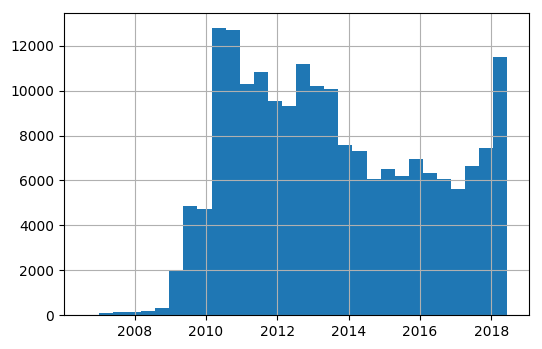

In [26]:
users_si.created_at.hist(bins=30)

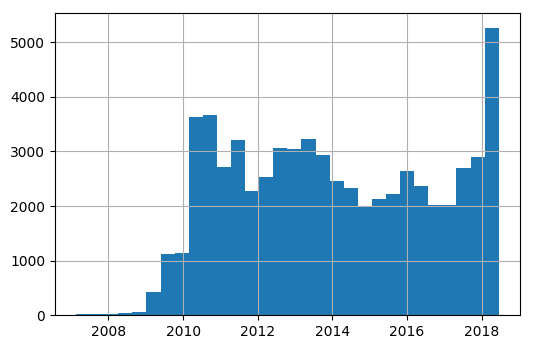

In [27]:
users_no.created_at.hist(bins=30)

## Cuentas verificadas

In [28]:
users_si.verified.value_counts()

False    193214
True     502   
Name: verified, dtype: int64

In [29]:
users_no.verified.value_counts()

False    64135
True     68   
Name: verified, dtype: int64

In [30]:
users_si[users_si.verified]

,created_at,description,favourites_count,followers_count,friends_count,geo_enabled,id,lang,location,name,protected,screen_name,statuses_count,time_zone,verified
2325,2010-06-16 11:45:01,El Trece - Radio Conexion Abierta,64723,383665,2528,True,156242969,es,Argentina,Luis Bremer,False,luisbremer,272602,None,True
2334,2010-08-01 19:29:48,Socióloga e investigadora. Activista del Nuevo Perú. Congresista de la República del Perú.,2490,249071,599,True,173544494,es,Peru,Marisa Glave,False,MarisaGlave,11125,None,True
2987,2011-02-25 12:05:58,Dirigente nacional del @PartidoObrero en el Frente de Izquierda,175,41003,506,True,257432060,es,Ciudad de Buenos Aires,Néstor Pitrola,False,nestorpitrola,31348,None,True
3194,2011-02-06 16:02:52,CONTRATACIONES e INFORMACION: Info@marianoberonmusic.com\nhttps://t.co/v2zpGtgV1G\n https://t.co/cyy6NwBUqV https://t.co/zifPcG4Lvc,31902,98604,293,True,248251555,es,Buenos Aires,Mariano Beron 🤪,False,Marianoberonok,7285,None,True
3320,2010-06-22 11:48:26,Secretario Gral. de @ahorapodemos y diputado en el Congreso. Profesor honorífico de la UCM. Nadie duda de que este país ya ha cambiado. ¡Sí se puede!,6526,2308222,2641,True,158342368,es,Madrid,Pablo Iglesias,False,Pablo_Iglesias_,18838,None,True
3799,2014-08-07 15:13:07,"Diputado del Parlasur. Ex Canciller de la Nación. Peronista. Sociólogo, Director del CIEP (UNSaM). Casado. Padre de tres hijxs.",1352,67952,558,False,2714771804,es,"Buenos Aires, Argentina",Jorge Taiana,False,JorgeTaiana,7228,None,True
3983,2010-05-17 03:21:22,1 0 3 0 #LAM,16403,3039071,18,True,144712423,es,,🅰️NGELITO,False,AngeldebritoOk,262357,None,True
4040,2008-08-05 15:57:57,Productor Musical - DJ - Conductor de #MinutosContados - Radio De Plata,23377,318262,5455,True,15737712,es,,camilogarcia,False,camilogarcia,34843,None,True
4146,2010-05-18 13:11:02,Trabaja en https://t.co/5BLPuJ72et y en el El Brío Teatro. Mis opiniones por acá son a título personal,1233,1257,646,False,145237113,es,,Germán Leza,False,yeisonleza,3522,None,True
4990,2012-02-10 03:06:49,"Asimétrico. Actor, autor, director, editor y pichón de productor. Creador de #ChicosCatolicos y #LaMadreQLP | 🔜 @salvajesok | Agus&Pedro | Funebrero🇾🇪",11842,16073,8456,True,488114005,es,Argentina,Juan Paya™,False,juancitopaya,32987,None,True


In [31]:
users_no[users_no.verified]

,created_at,description,favourites_count,followers_count,friends_count,geo_enabled,id,lang,location,name,protected,screen_name,statuses_count,time_zone,verified
1153,2008-12-03 04:06:54,Cuenta Oficial de ACI Prensa | Noticias y recursos sobre la Iglesia Católica en todo el mundo.,1462,262695,970,True,17828368,es,,ACI Prensa,False,aciprensa,74215,None,True
3149,2012-02-02 00:36:50,No respondo mensajes privados.,30886,289880,32188,True,480860644,es,,Viviana,False,vivicanosaok,19649,None,True
3983,2010-05-17 03:21:22,1 0 3 0 #LAM,16403,3039071,18,True,144712423,es,,🅰️NGELITO,False,AngeldebritoOk,262357,None,True
12331,2015-11-16 00:55:37,"Presidente del Bloque PRO, Honorable Cámara de Diputados de la Nación",94,35876,142,True,4198001913,en,,Nicolás Massot,False,Nicolas_Massot,676,None,True
18422,2008-09-15 11:08:46,"Noticias desde Buenos Aires, Argentina. Periodismo puro en tiempo real.",276,738338,2207,True,16294264,es,Argentina,Perfil.com,False,perfilcom,170254,None,True
18564,2010-06-29 18:14:55,"Argentina, politóloga, madre de 3 hijos maravillosos y Secretaria de Infraestructura Urbana de la Nación.",3330,22908,846,True,160998065,es,Ciudad Autónoma de Buenos Aire,Marina Klemensiewicz,False,Klemensiewicz,5189,None,True
22700,2010-10-09 01:04:54,Cuenta Oficial de la Periodista de Espectaculos en @telefenoticias @buentelefe Corresponsal argentina de HOLATV para Miami y Latinoamerica. Canal 26/Late93.1,15712,257314,3308,True,200328797,es,argentina,Pilar Smith,False,Pilarsmith,44597,None,True
23054,2012-07-17 12:35:08,Todo Jujuy Diario digital. Noticias al instante las 24 hs.,562,15914,255,True,700978591,es,San Salvador de Jujuy,Todo Jujuy,False,diarioTodoJujuy,65031,None,True
25623,2009-09-03 21:11:47,"Coordinador de Análisis y Control de Gestión del @SFMyC.\n\nReflexiono sobre Liderazgo y desarrollo personal.\nCasado, 4 hijos. 💙💛💙\n https://t.co/gjF0xfAjRo",61292,94576,744,True,71360442,es,"Buenos Aires, Argentina",Ricardo R Benedetti,False,RicBenedetti,19438,None,True
26857,2011-01-13 03:26:06,"Bienvenidos a la cuenta oficial de Revista Noticias, el newsmagazine de lengua hispana más leído del mundo.",453,256854,1418,True,237562389,es,,Revista Noticias,False,noticiasrevista,17483,None,True
